In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os

import tensorflow as tf
from keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator
from keras.layers import Dense,Input,Dropout, GlobalAveragePooling2D,Flatten,Conv2D, BatchNormalization,Activation,MaxPooling2D
from keras.models import load_model,Model,Sequential
from keras.optimizers import Adam,SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
!pip install kaggle

In [3]:
 !pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

100% 120M/121M [00:06<00:00, 19.2MB/s]
100% 121M/121M [00:06<00:00, 18.9MB/s]


In [4]:
!unzip face-expression-recognition-dataset

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [7]:
pic_size=48
folder_path='/content/images/images/'


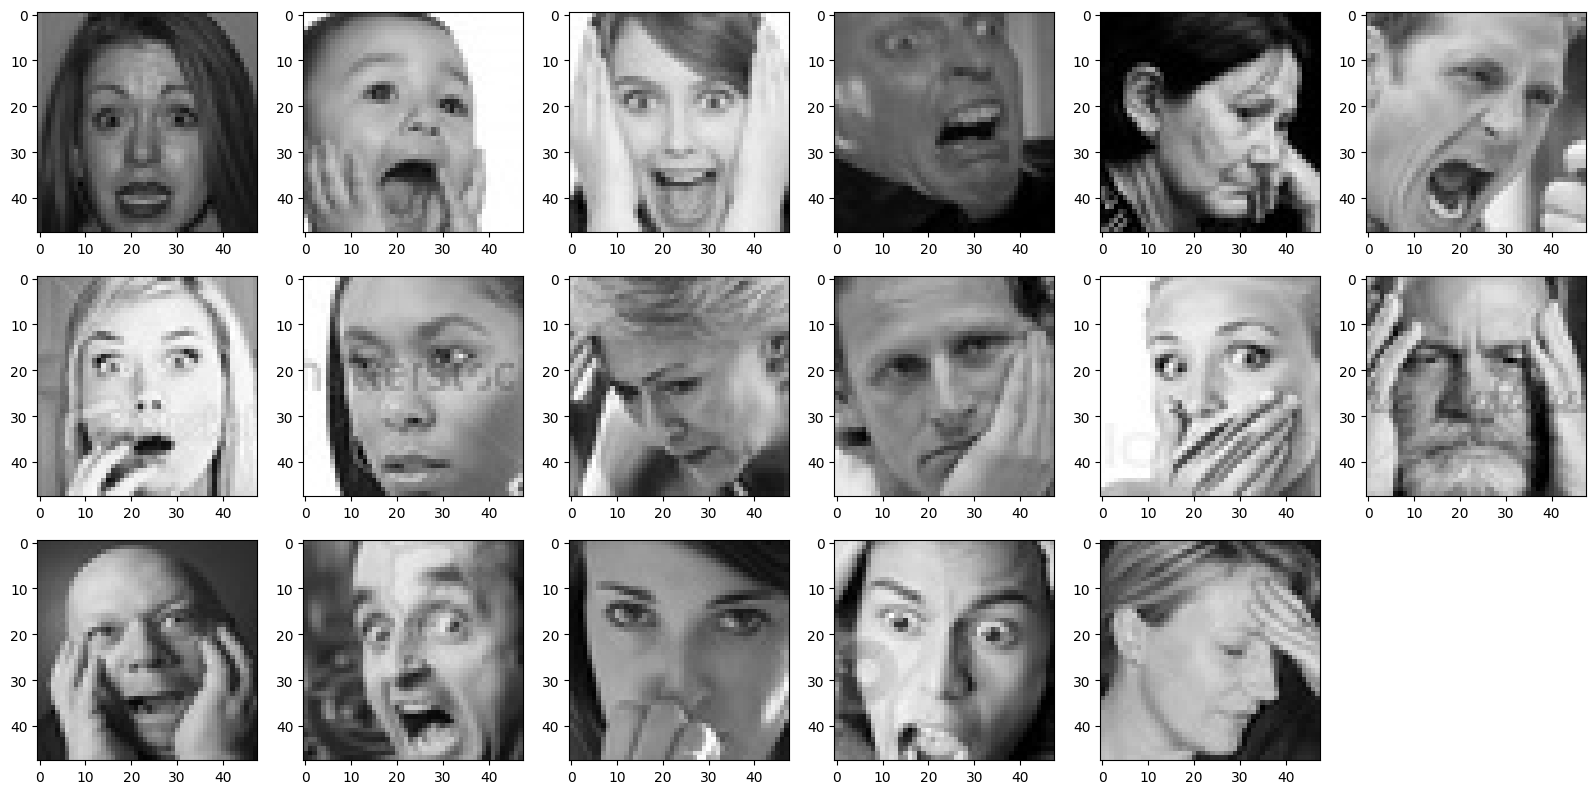

In [8]:
expression='fear'

plt.figure(figsize=(20,20))
for i in range(1,18,1):
    plt.subplot(6,6,i)
    img=load_img(folder_path+'train/'+expression+"/"+
                os.listdir(folder_path + 'train/' + expression)[i],target_size=(pic_size,pic_size))
    plt.imshow(img)
plt.show()

In [9]:
batch_size = 128

datagen_train= ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)
datagen_val = ImageDataGenerator(rescale= 1.0/255)

train_set = datagen_train.flow_from_directory(folder_path+'train',target_size=(pic_size,pic_size),color_mode='grayscale',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

test_set= datagen_val.flow_from_directory(folder_path+'validation',
                                            target_size=(pic_size,pic_size),
                                            color_mode='grayscale',
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [10]:
no_of_classes=7
model=Sequential()

#1st CNN Layer
model.add(Conv2D(64,(3,3),padding='same', input_shape=(48,48,1)) )
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2nd CNN Layer
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.25))

#3rd CNN Layer
model.add(Conv2D(512,(3,3), padding=('same')))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th CNN Layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

#fully connected 1st Layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Fully connected 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Final Output Layer
model.add(Dense(no_of_classes, activation='softmax'))


opt=Adam(learning_rate=.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [12]:
# number of epochs to train the NN
epochs = 200

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint=ModelCheckpoint(filepath='./modelbestweights.h5', mode='max', monitor='val_accuracy', verbose=1, save_best_only
                           =True)



callbacks_list=[checkpoint]


model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=.001),metrics=['accuracy'])

In [13]:
history=model.fit_generator(train_set,
                           steps_per_epoch=train_set.n//train_set.batch_size,
                           epochs=epochs,
                           validation_data=test_set,
                           validation_steps=test_set.n//test_set.batch_size,
                           callbacks=callbacks_list)

Epoch 1/200


<ipython-input-13-b59089af9fcc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_set,


225/225 [==============================] - ETA: 0s - loss: 1.9150 - accuracy: 0.2453
Epoch 1: val_accuracy improved from -inf to 0.25923, saving model to ./modelbestweights.h5
225/225 [==============================] - 42s 136ms/step - loss: 1.9150 - accuracy: 0.2453 - val_loss: 1.8832 - val_accuracy: 0.2592


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
225/225 [==============================] - ETA: 0s - loss: 1.6539 - accuracy: 0.3538
Epoch 2: val_accuracy improved from 0.25923 to 0.27443, saving model to ./modelbestweights.h5
225/225 [==============================] - 29s 129ms/step - loss: 1.6539 - accuracy: 0.3538 - val_loss: 1.8126 - val_accuracy: 0.2744
Epoch 3/200
225/225 [==============================] - ETA: 0s - loss: 1.4886 - accuracy: 0.4216
Epoch 3: val_accuracy improved from 0.27443 to 0.42614, saving model to ./modelbestweights.h5
225/225 [==============================] - 32s 141ms/step - loss: 1.4886 - accuracy: 0.4216 - val_loss: 1.4524 - val_accuracy: 0.4261
Epoch 4/200
225/225 [==============================] - ETA: 0s - loss: 1.3746 - accuracy: 0.4724
Epoch 4: val_accuracy improved from 0.42614 to 0.47330, saving model to ./modelbestweights.h5
225/225 [==============================] - 29s 130ms/step - loss: 1.3746 - accuracy: 0.4724 - val_loss: 1.4069 - val_accuracy: 0.4733
Epoch 5/200
225/225 [====

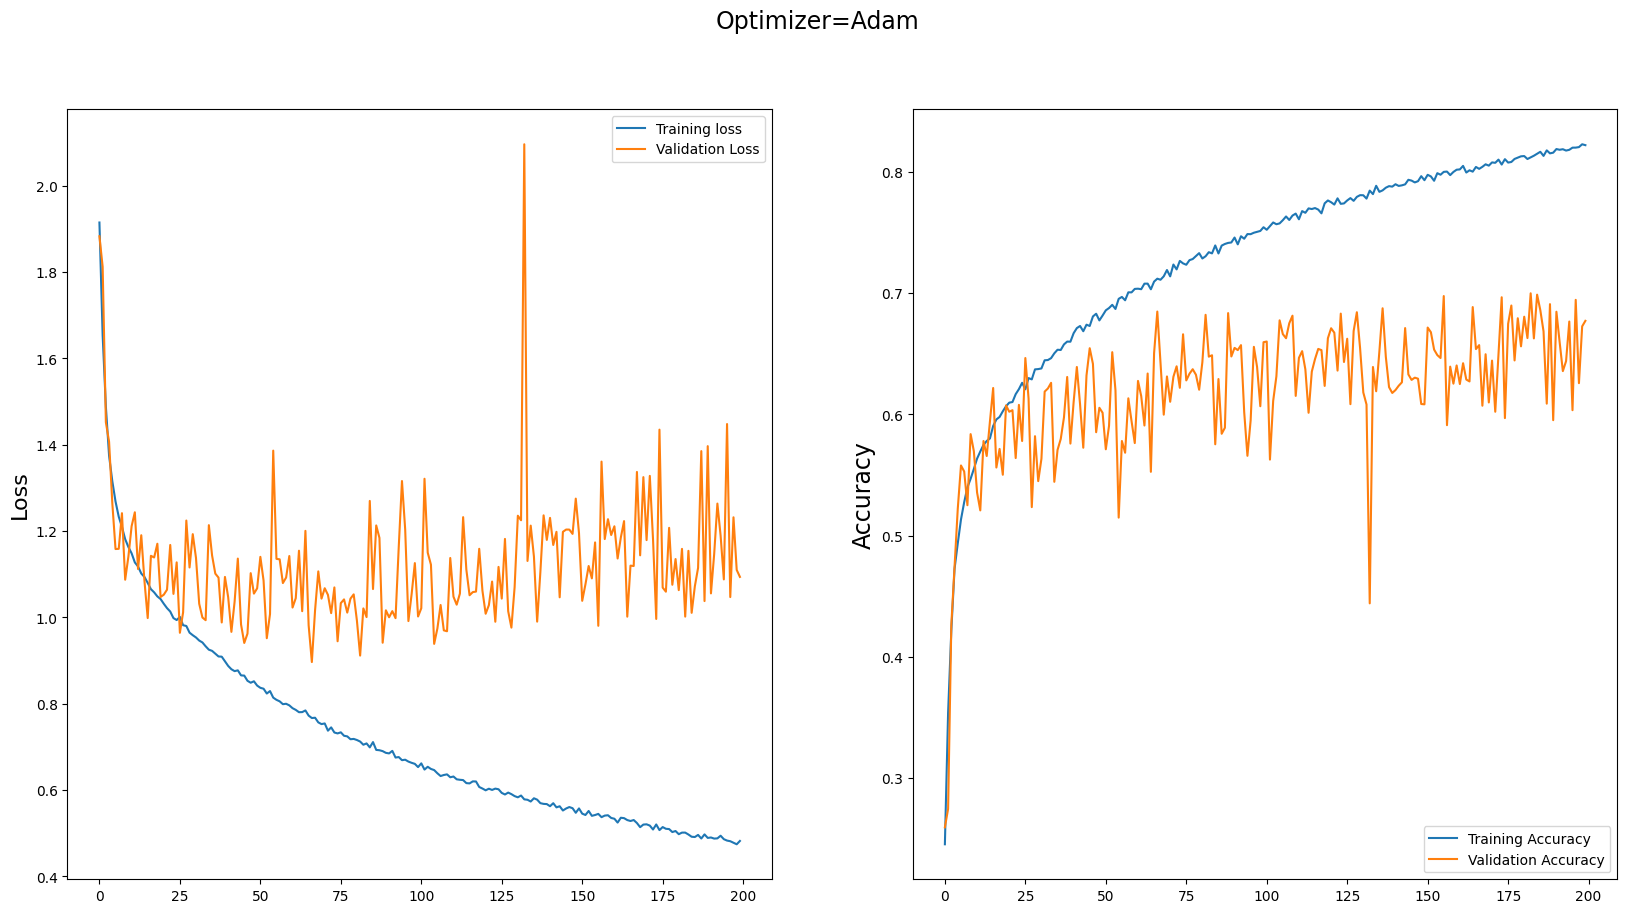

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.suptitle('Optimizer=Adam', fontsize=17)
plt.ylabel('Loss',fontsize=16)
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize=17)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


In [18]:
op = dict(zip( train_set.class_indices.values(), train_set.class_indices.keys()))

1/1 [==============================] - 0s 62ms/step
The image is of sad


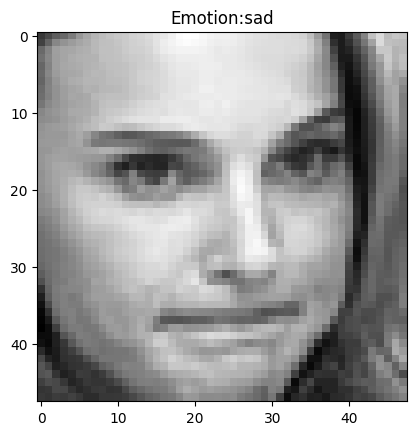

In [26]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

path = "/content/images/validation/sad/11100.jpg"
img = load_img(path, color_mode="grayscale", target_size=(48, 48))

# Convert the image to a numpy array and normalize
i = img_to_array(img) / 255
input_arr = np.array([i])

# Ensure the input shape is correct
assert input_arr.shape == (1, 48, 48, 1), f"Expected input shape (1, 48, 48, 1), but got {input_arr.shape}"

# Make a prediction
pred = np.argmax(model.predict(input_arr))

print(f"The image is of {op[pred]}")

# Display the image
plt.imshow(input_arr[0, :, :, 0], cmap='gray')  # Assuming a grayscale image
plt.title(f"Emotion:{op[pred]}")
plt.show()


In [ ]:
from keras.models import load_model
from time import sleep
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml")
classifier =load_model('/content/modelbestweights.h5')

emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']

cap = cv2.VideoCapture(0)



while True:
    _, frame = cap.read()
    labels = []
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)



        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)

            prediction = classifier.predict(roi)[0]
            label=emotion_labels[prediction.argmax()]
            label_position = (x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
        else:
            cv2.putText(frame,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the best weights
model.load_weights('./modelbestweights.h5')

# Predict on the test set
y_pred = model.predict(test_set, steps=len(test_set), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_set.classes

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Print classification report
class_labels = list(test_set.class_indices.keys())
class_report = classification_report(y_true, y_pred_classes, target_names=class_labels)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


56/56 [==============================] - 5s 91ms/step
Confusion Matrix:
[[ 584   13   53   34  136  124   16]
 [  18   80    3    1    2    5    2]
 [ 121    5  482   34  111  208   57]
 [  22    0   25 1613  106   36   23]
 [  62    0   31   75  865  163   20]
 [  90    2   73   36  229  696   13]
 [  18    2   66   40   26   18  627]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.64      0.61      0.62       960
     disgust       0.78      0.72      0.75       111
        fear       0.66      0.47      0.55      1018
       happy       0.88      0.88      0.88      1825
     neutral       0.59      0.71      0.64      1216
         sad       0.56      0.61      0.58      1139
    surprise       0.83      0.79      0.81       797

    accuracy                           0.70      7066
   macro avg       0.70      0.69      0.69      7066
weighted avg       0.71      0.70      0.70      7066

